<a href="https://colab.research.google.com/github/papchukev/demo/blob/main/%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%80%D0%B5%D0%B7%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D1%82%D0%BE%D0%B2_%D0%90%D0%92%D1%82%D0%B5%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание 10. A/B тестирование.

Кейс: a/b-тест для мобильного приложения.

Имеется мобильное приложение для магазина по продаже продуктов питания. Выдвинута гипотеза о том, что смена шрифтов улучшит качество обслуживания по количеству клиентов, совершающих каждое событие. Для проверки этой гипотезы принято решение провести A/B-тест.   

Пользователей разбили на 2 группы:

247 -- контрольная группа со старыми шрифтами;

248 -- экспериментальная с новыми шрифтами.

Описание данных

|Признак|Комментарий|
|--:|:--|
|`EventName`|название события|
|`DeviceIDHash`|уникальный идентификатор пользователя|
|`EventTimestamp`|время события|
|`ExpId`|номер группы|

Инструкция по выполнению проекта

Шаг 1. Загрузка данных
- Знакомство с данными;
- Корректность a/b-теста.

Шаг 2. Подготовка данных
- Корректировка заголовков;
- Типы данных;
- Аномалии, пропуски.

Шаг 3. EDA
- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

Шаг 4. Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряете больше всего пользователей?
Какая доля пользователей доходит от первого события до оплаты?

Шаг 5. Анализ результатов эксперимента
- Сколько пользователей в каждой группе?
- Посчитайте долю пользователей, совершивших каждое из событий.
- Проверьте гипотезу о наличие значимых отличий по результатам теста.

# Шаг 1. Загрузите данные

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from scipy import stats
import math

In [ ]:
df = pd.read_csv('/content/ab_test_home.csv')
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
2,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
3,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248
4,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247
...,...,...,...,...
163817,MainScreenAppear,2300292234025330845,2019-08-07 21:05:57,247
163818,MainScreenAppear,5317814261427487562,2019-08-07 21:09:22,248
163819,OffersScreenAppear,5317814261427487562,2019-08-07 21:09:27,248
163820,OffersScreenAppear,5317814261427487562,2019-08-07 21:10:08,248


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163822 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       163822 non-null  object
 1   DeviceIDHash    163822 non-null  int64 
 2   EventTimestamp  163822 non-null  object
 3   ExpId           163822 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 5.0+ MB


In [ ]:
df.ExpId.value_counts()

248    85747
247    78075
Name: ExpId, dtype: int64

# Шаг 2. Подготовьте данные

In [ ]:
df.rename(columns = {'EventName' : 'event',
                     'DeviceIDHash' : 'device_id',
                     'EventTimestamp' : 'event_time',
                     'ExpId' : 'group_id'},
          inplace = True);

In [ ]:
df['event_time'] = pd.to_datetime(df['event_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163822 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       163822 non-null  object        
 1   device_id   163822 non-null  int64         
 2   event_time  163822 non-null  datetime64[ns]
 3   group_id    163822 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.0+ MB


In [ ]:
df.duplicated().sum()

290

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
#проверка на общих пользователей в двух группах
a = set(df[df.group_id == 247].device_id.unique())

b = set(df[df.group_id == 248].device_id.unique())

a.intersection(b)

set()

In [ ]:
df.groupby('device_id')['device_id'].agg(['count']).reset_index().\
sort_values(by = 'count', ascending = False).head(5)

,device_id,count
3462,6304868067479728361,2307
2496,4623191541214045580,1768
3766,6932517045703054087,1439
930,1754140665440434215,1221
2556,4713748699910253089,824


# Шаг 3. EDA

-Cколько всего событий?

-Сколько всего пользователей в логе?

-Сколько в среднем событий приходится на пользователя?

-Период теста: максимальная и минимальная даты, гистограмма по дате и количеству событий.

In [ ]:
# Cколько всего событий? Сколько всего пользователей в логе? Сколько в среднем событий приходится на пользователя?
print("""
Всего событий: {}
Уникальных событий {}: {}
Уникальных пользователей: {}
Среднее количество событий на одного пользователя: {}
""".format(df.shape[0],df.event.nunique(), df.event.unique(),
           df.device_id.nunique(), round(df.shape[0] / df.device_id.nunique())))


Всего событий: 163532
Уникальных событий 5: ['PaymentScreenSuccessful' 'CartScreenAppear' 'MainScreenAppear'
 'Tutorial' 'OffersScreenAppear']
Уникальных пользователей: 5062
Среднее количество событий на одного пользователя: 32



In [ ]:
# Период теста: максимальная и минимальная даты, гистограмма по дате и количеству событий.
print("""
Начало теста {}
Конец теста {}
""".format(df.event_time.min(), df.event_time.max()))


Начало теста 2019-07-25 11:28:47
Конец теста 2019-08-07 21:12:25



In [ ]:
df['event_date'] = df['event_time'].dt.date

df_event_count = df.groupby('event_date')['event'].agg(['count']).reset_index()

In [ ]:
df_event_count

,event_date,count
0,2019-07-25,5
1,2019-07-26,17
2,2019-07-27,31
3,2019-07-28,72
4,2019-07-29,129
5,2019-07-30,283
6,2019-07-31,1410
7,2019-08-01,24580
8,2019-08-02,24608
9,2019-08-03,22707


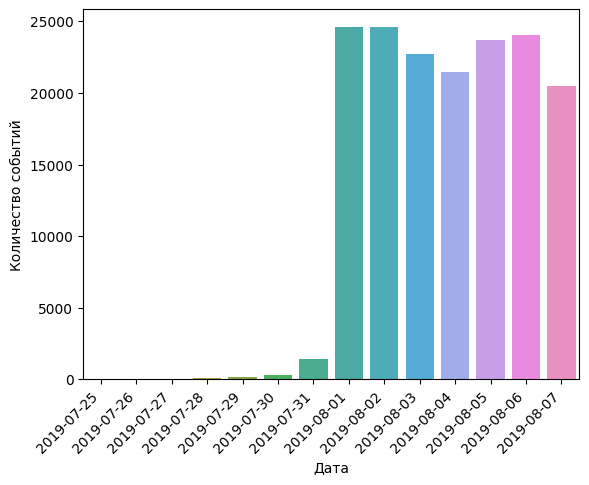

In [ ]:
ax = sns.barplot(df_event_count, x = 'event_date', y = 'count')
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
plt.xlabel('Дата')
plt.ylabel('Количество событий');

# Шаг 4. Анализ воронки событий

-Распределение событий: какие события и в каком количестве.

-Сколько пользователей совершали каждое из этих событий?

-Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряете больше всего пользователей? Какая доля пользователей доходит от первого события до оплаты?

In [ ]:
# Распределение событий: какие события и в каком количестве.
df.groupby('event')['event'].agg(['count']).reset_index().\
sort_values(by = 'count', ascending = False)

,event,count
1,MainScreenAppear,80852
2,OffersScreenAppear,31904
0,CartScreenAppear,27870
3,PaymentScreenSuccessful,22206
4,Tutorial,700


In [ ]:
# Сколько пользователей совершали каждое из этих событий?
df_event_users = df.groupby('event')['device_id'].agg(['nunique']).reset_index().\
sort_values(by = 'nunique', ascending = False)
df_event_users

,event,nunique
1,MainScreenAppear,4983
2,OffersScreenAppear,3068
0,CartScreenAppear,2479
3,PaymentScreenSuccessful,2345
4,Tutorial,568


In [ ]:
# Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки.
# На каком шаге теряете больше всего пользователей?
# Какая доля пользователей доходит от первого события до оплаты?
df_event_users = df_event_users.loc[df_event_users['event'] != 'Tutorial']
df_event_users

,event,nunique
1,MainScreenAppear,4983
2,OffersScreenAppear,3068
0,CartScreenAppear,2479
3,PaymentScreenSuccessful,2345


In [ ]:
fig = plotly.graph_objects.Figure()

fig.add_trace(plotly.graph_objects.Funnel(
    name = 'Пользователи',
    orientation = "h",
    y = df_event_users['event'],
    x = df_event_users['nunique'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"))
fig.show()

- 62% от начального числа пользователей проходит шаг OffersScreenAppear, из них 81% пользователей проходит шаг CartScreenAppear, из которых 95% пользователей проходит шаг PaymentScreenSuccessful;
- больше всего пользователей теряется на шаге OffersScreenAppear -- 38%;
- от первого события до оплаты доходит 47% пользователей

# Шаг 5. Анализ результатов эксперимента

In [ ]:
df.head(2)

,event,device_id,event_time,group_id,event_date
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25


In [ ]:
# Сколько пользователей в каждой группе?
# Посчитайте долю пользователей, совершивших каждое из событий.

df_event_group = pd.merge(df[df['group_id'] == 247].groupby('event').\
                          agg(count_247 = ('device_id', 'nunique')).\
                          reset_index().sort_values(by = 'count_247',
                                                    ascending = False),
                          df[df['group_id'] == 248].groupby('event').\
                          agg(count_248 = ('device_id', 'nunique')).\
                          reset_index().sort_values(by = 'count_248',
                                                    ascending = False))
df_event_group

,event,count_247,count_248
0,MainScreenAppear,2482,2501
1,OffersScreenAppear,1530,1538
2,CartScreenAppear,1240,1239
3,PaymentScreenSuccessful,1160,1185
4,Tutorial,286,282


In [ ]:
df_group_users = df.groupby('group_id').agg(group_users = ('device_id',
                                                           'nunique'))
df_group_users

,group_users
group_id,
247,2520
248,2542


In [ ]:
df_event_group['procent_247'] = np.round(
    df_event_group['count_247'] / df_group_users.loc[247][0],
    4)
df_event_group['procent_248'] = np.round(
    df_event_group['count_248'] / df_group_users.loc[248][0],
    4)
df_event_group

,event,count_247,count_248,procent_247,procent_248
0,MainScreenAppear,2482,2501,0.9849,0.9839
1,OffersScreenAppear,1530,1538,0.6071,0.6050
2,CartScreenAppear,1240,1239,0.4921,0.4874
3,PaymentScreenSuccessful,1160,1185,0.4603,0.4662
4,Tutorial,286,282,0.1135,0.1109


In [ ]:
fig1 = plotly.graph_objects.Figure()

fig1.add_trace(plotly.graph_objects.Funnel(
    name = 'Пользователи группы 247',
    orientation = "h",
    y = df_event_group['event'],
    x = df_event_group['count_247'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"))

fig1.add_trace(plotly.graph_objects.Funnel(
    name = 'Пользователи группы 248',
    orientation = "h",
    y = df_event_group['event'],
    x = df_event_group['count_248'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"))

fig1.show()

Проверьте гипотезу о наличие значимых отличий по результатам теста.

$H_0$ : *нет статистически значимых отличий в количестве пользователей, совершивших каждое событие, по группам "247" и "248".*

$H_1$ : *имеются статистически значимые отличия в количестве пользователей, совершивших каждое событие, по группам "247" и "248".*

In [ ]:
df_event_group

,event,count_247,count_248,procent_247,procent_248
0,MainScreenAppear,2482,2501,0.9849,0.9839
1,OffersScreenAppear,1530,1538,0.6071,0.6050
2,CartScreenAppear,1240,1239,0.4921,0.4874
3,PaymentScreenSuccessful,1160,1185,0.4603,0.4662
4,Tutorial,286,282,0.1135,0.1109


In [ ]:
df_group_users

,group_users
group_id,
247,2520
248,2542


In [ ]:
def z_test(group1, group2, event, alpha):
    p1_ev = df_event_group.loc[event, group1]
    p2_ev = df_event_group.loc[event, group2]
    p1_us = df_group_users.loc[247][0]
    p2_us = df_group_users.loc[248][0]
    p1 = p1_ev / p1_us
    p2 = p2_ev / p2_us
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us)
    z_value = (difference / math.sqrt(p_combined * (1 - p_combined) *
     (1 / p1_us + 1 / p2_us)))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print("""---
---
Группы {} и {}.
Событие -- {}.
P-значение --  {:.2f}. Уровень значимости -- {}""".format(group1, group2,
                                                              event, p_value,
                                                              alpha ))
    if (p_value < alpha):
        print("\nP-значение < Уровень значимости, поэтому отвергаем нулевую гипотезу -- между долями есть значимая разница")
    else:
        print("\nP-значение > Уровень значимости, поэтому принимаем нулевую гипотезу, нет оснований считать доли разными")

In [ ]:
df_event_group.index = df_event_group.event

In [ ]:
for event in df_event_group.event.values:
    z_test('count_247', 'count_248', event, 0.05)

---
---
Группы count_247 и count_248. 
Событие -- MainScreenAppear. 
P-значение --  0.76. Уровень значимости -- 0.05

P-значение > Уровень значимости, поэтому принимаем нулевую гипотезу, нет оснований считать доли разными
---
---
Группы count_247 и count_248. 
Событие -- OffersScreenAppear. 
P-значение --  0.88. Уровень значимости -- 0.05

P-значение > Уровень значимости, поэтому принимаем нулевую гипотезу, нет оснований считать доли разными
---
---
Группы count_247 и count_248. 
Событие -- CartScreenAppear. 
P-значение --  0.74. Уровень значимости -- 0.05

P-значение > Уровень значимости, поэтому принимаем нулевую гипотезу, нет оснований считать доли разными
---
---
Группы count_247 и count_248. 
Событие -- PaymentScreenSuccessful. 
P-значение --  0.68. Уровень значимости -- 0.05

P-значение > Уровень значимости, поэтому принимаем нулевую гипотезу, нет оснований считать доли разными
---
---
Группы count_247 и count_248. 
Событие -- Tutorial. 
P-значение --  0.77. Уровень значимости --